## Практическое задание 2: Линейные модели, часть 1: Регрессия

In [ ]:
! pip install numpy pandas scipy matplotlib seaborn scikit-learn nltk gdown

In [35]:
# !!! Данный блок будет работать только в Google-Colab !!!
# Устанавливаем урезанную версию requeirements.txt для ускорения установки
# Если будут всплывать ошибки о несовместимости библиотек, то ничего страшного
# На это задание они не влияют

! gdown 1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199

Downloading...
From: https://drive.google.com/uc?id=1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199
To: /content/requirements_small.txt
100% 374/374 [00:00<00:00, 1.24MB/s]


-----------
<font color="white" style="opacity:0.2023"></font>

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
sns.set(style="darkgrid")
%matplotlib inline

## Часть 1. Линейная регрессия

Напомним, что линейная регрессия — это модель следующего вида: $$a(x) = \langle w, x \rangle + b$$ где $w \in \mathbb{R}^d$, $b \in \mathbb{R}$. Обучить линейную регрессию — значит найти $w$ и $b$.

Для обучения линейной регрессии, равно как и для обучения остальных простых моделей (линейные модели, решающие деревья, knn и т.д.) отлично подходит библиотека scikit-learn (sklearn): в ней очень понятный и простой интерфейс.

Так как мы будем обучать линейную регрессию, нам подойдет реализация из sklearn. В sklearn есть несколько классов, реализующих линейную регрессию. Основные это:

- Ridge — линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
- Lasso — линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией

Также есть SVR, ElasticNet  и пр., но не будем сегодня о них

У моделей из sklearn есть методы fit и predict. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке.

Рассмотрим, модельные данные для задачи регрессии. Пусть $x$ будет обычным числом из равномерного распределения, а $y = 0.5 \cdot x + 0.1$ &mdash; целевая переменная. При этом наблюдаем мы $\overline{y} = y + \varepsilon,~\varepsilon \sim \mathcal{N}(0, 0.01)$.

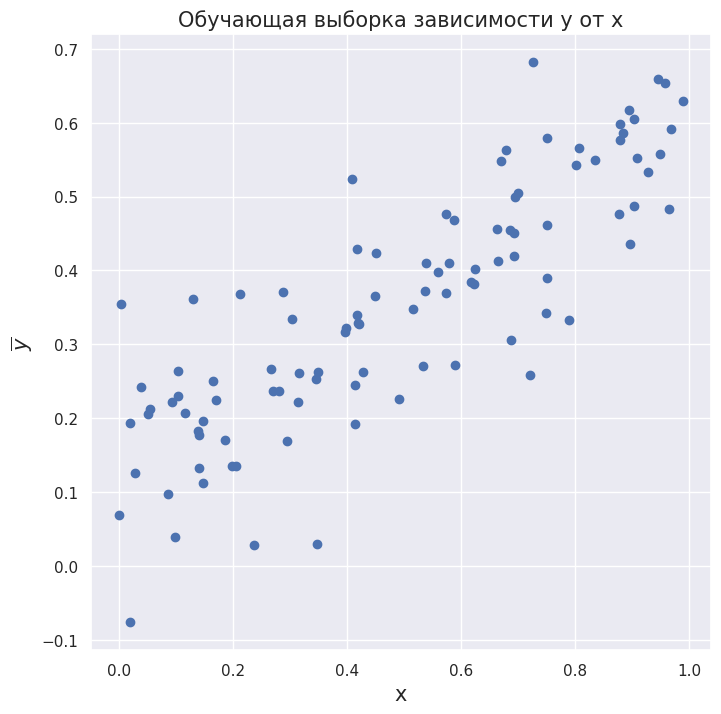

In [ ]:
np.random.seed(1)
X = np.random.uniform(0, 1, 100)
Y = X * 0.5 + 0.1 + np.random.randn(100) * 0.1

plt.figure(figsize=(8, 8))
plt.scatter(X, Y)
plt.title("Обучающая выборка зависимости y от x", size=15)
plt.xlabel("x", size=15)
plt.ylabel(r'$\overline{y}$', size=15)
plt.show()

Обучим линейную регрессию, и посмотрим как регуляризация влияет на качество модели. В реализации библиотеки sklearn коэффициент регуляризации задаётся параметром alpha

In [ ]:
from sklearn.linear_model import Ridge

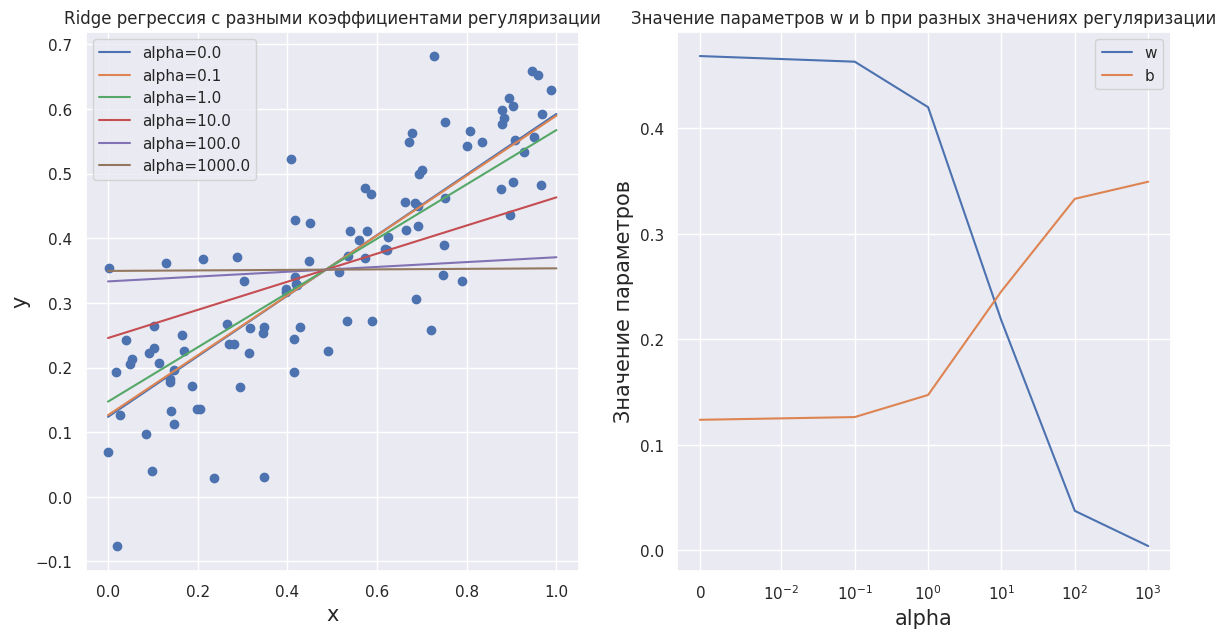

In [ ]:
x_axis = np.linspace(0, 1, 200)
fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
axs[0].scatter(X, Y)

w = []
b = []

alphas = [0.0, 0.1, 1.0, 10.0, 100.0, 1000.0]

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X[:, None], Y)
    pred = reg.predict(x_axis[:, None])
    w.append(reg.coef_[0])
    b.append(reg.intercept_)
    axs[0].plot(x_axis, pred, label="alpha=" + str(alpha))

axs[0].legend()
axs[0].set_xlabel("x", size=15)
axs[0].set_ylabel("y", size=15)
axs[0].set_title("Ridge регрессия с разными коэффициентами регуляризации")
axs[1].plot(alphas, w, label="w")
axs[1].plot(alphas, b, label="b")
axs[1].set_xlabel("alpha", size=15)
axs[1].set_ylabel("Значение параметров", size=15)
axs[1].set_title("Значение параметров w и b при разных значениях регуляризации")
axs[1].set_xscale("symlog", linthresh=0.01)
axs[1].legend()
plt.show()

### **Вопрос 1** (1 балл)

Как зависят параметры модели от константы регуляризации? А качество?



Чем больше константа регуляризации, тем меньше коэфицент w и больше коэфицент b, потому что и без регуляризации модель хорошо работает (данные чистые, целевая переменная напрямую зависит только от одной переменной) => чем больше константа регуляриазции, тем хуже качество модели.

### **Вопрос 2** (1 балл)

Почему при обучении линейных моделей, коэффициент $b$ не регуляризуется? Дайте ответ с опорой на лекции и увиденные картинки.

Потому что он не связан с данными напрямую как веса.

------

Казалось бы, зачем нам эта глупая регуляризация?!

Давайте рассмотрим ещё один модельный пример. Представим, что кто-то добавил в данные к переменной $x$ её же умноженную на $2$. То есть, теперь у нас два признака $x_1$ и $x_2 = 2 \cdot x_1$. Тогда, $y = c \cdot 0.5 \cdot x_1 + \frac{1 - c}{4} \cdot x_2 + 0.1$, где $c$ любое сколь угодно большое вещественное число. Это может привести к тому, что без регуляризации мы рискуем выучить очень большие веса!

In [ ]:
np.random.seed(1)
X2 = np.hstack((X[:, None], 2 * X[:, None]))
Y2 = X2[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X2, Y2)
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

w1: 0.10062207382659173 	w2: 0.20124414765318352


Коэффициенты адекватные, хотя и не похожи на изначальную зависимость. Но что, если $x_2$ будет равняться $3 \cdot x_1$?

In [ ]:
np.random.seed(1)
X3 = np.hstack((X[:, None], 3 * X[:, None]))
Y3 = X3[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X3, Y3)
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

w1: 20443435586638.32 	w2: -6814478528879.271


Тут вот уже не повезло. Коэффициенты случайно выучились неадекватно большими. Создадим обучающую выборку из того же распределения и посмотрим на качество

In [ ]:
np.random.seed(2)
X3_test = np.random.uniform(0, 1, 100)
X3_test = np.hstack((X3_test[:, None], 3 * X3_test[:, None]))
Y3_test = X3_test[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

Y3_test_pred = np.sum(reg.coef_[None] * X3_test + reg.intercept_, axis=1)
print("MSE loss: %.4f" % np.mean((Y3_test_pred - Y3_test) ** 2))

MSE loss: 0.0208


Вроде бы неплохое, но что если мы добавим ко второму признаку одного из объектов небольшой шум?

In [ ]:
X3_test[0, 1] = X3_test[0, 1] + 1e-10
Y3_test_pred_noisy = np.sum(reg.coef_[None] * X3_test + reg.intercept_, axis=1)
print("MSE loss:", np.mean((Y3_test_pred_noisy - Y3_test) ** 2))
print("Предсказание для первого объекта с шумом: ", Y3_test_pred_noisy[0])
print("Предсказание для первого объекта без шума: ", Y3_test_pred[0])

MSE loss: 4641.705812262879
Предсказание для первого объекта с шумом:  -681.02734375
Предсказание для первого объекта без шума:  0.419921875


Как видим, даже небольшое изменение в данных, приводит к резкому падению качества.

### **Вопрос 3** (2 балла)
Рассмотрите больше примеров с двумя признаками $x_1$ и $x_2$, где $x_2$ линейно зависит от $x_1$. Убедитесь, что линейная модель без регуляризации крайне неустойчива.

In [ ]:
np.random.seed(1)
X3 = np.hstack((X[:, None], -10 * X[:, None]))
Y3 = X3[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X3, Y3)
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

w1: 14779777306790.664 	w2: 1477977730679.0156


In [ ]:
import math

In [ ]:
np.random.seed(1)
X3 = np.hstack((X[:, None], math.pi * X[:, None]))
Y3 = X3[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

reg = Ridge(alpha=0.0)
reg.fit(X3, Y3)
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])

w1: -377542884930.9871 	w2: 120175632732.04263


-----

Теперь добавим регуляризацию и посмотрим, как меняется значения весов, в зависимости от значения коэффициента регуляризации.

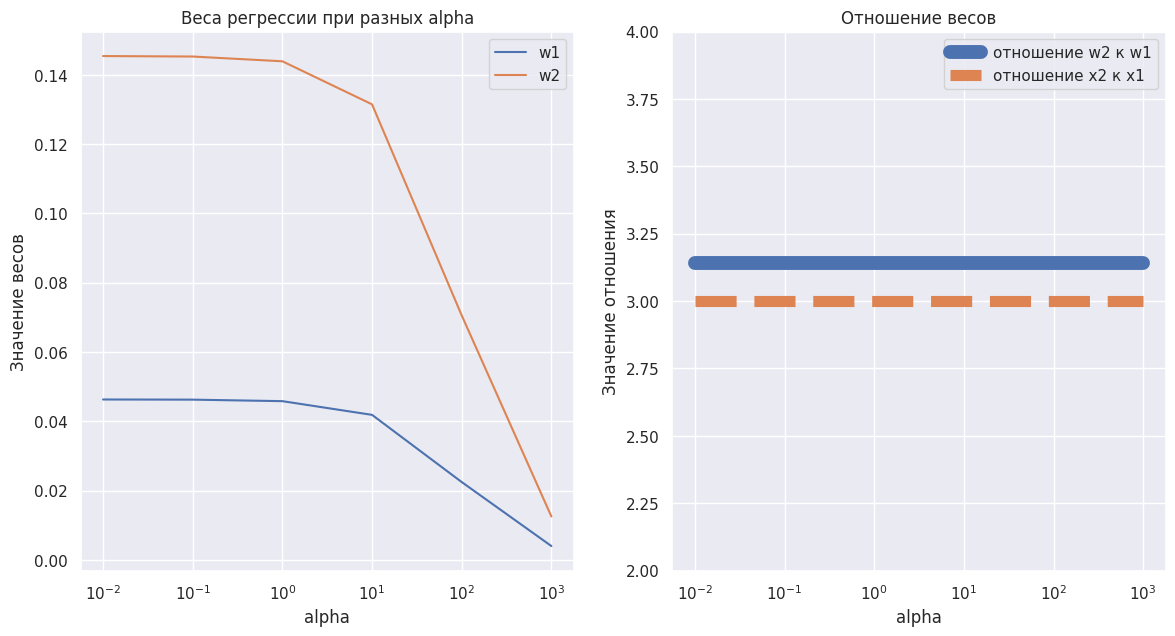

In [ ]:
w1 = []
w2 = []

alphas = [0.01, 0.1, 1, 10, 100, 1000]

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X3, Y3)
    w1.append(reg.coef_[0])
    w2.append(reg.coef_[1])

w1 = np.array(w1)
w2 = np.array(w2)

fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
axs[0].plot(alphas, w1, label="w1")
axs[0].plot(alphas, w2, label="w2")
axs[0].set_xscale("log")
axs[0].set_title("Веса регрессии при разных alpha")
axs[0].set_xlabel("alpha")
axs[0].set_ylabel("Значение весов")
axs[0].legend()
axs[1].plot(alphas, w2 / w1, label="отношение w2 к w1", linewidth=10)
axs[1].plot([0.01, 1000], [3, 3], label="отношение x2 к x1", linestyle="--", linewidth=8)
axs[1].set_xscale("log")
axs[1].set_ylim(2,4)
axs[1].set_xlabel("alpha")
axs[1].set_ylabel("Значение отношения")
axs[1].set_title("Отношение весов")
axs[1].legend()
plt.show()

### **Вопрос 4 (со звёздочкой)** (2 балла)

Как думаете, почему отношение между весами постоянно? (подсказка, необходимо выписать функцию потерь и посчитать производные по весам)

https://femboy.beauty/ESRREi

-----
<font color="white" style="opacity:0.2023"></font>

Заметим, что при $l_2$ регуляризации в данном примере веса получились пропорциональны значениям признаков. При этом, мы знаем, что оба признака взаимно однозначны, и прогноз можно делать только по одному из них. Для этого придумана $l_1$ регуляризация. В билиотеке sklearn линейная регрессия с $l_1$ регуляризацией реализована в классе Lasso

### **Вопрос 5** (2 балла)

Почему в нашем примере $l_1$ регуляризация приведёт к разреживанию весов? (подсказка, нужно опять подсчитать производную, но обратите внимание на дифференцируемость модуля).

**Ваш ответ здесь**

-----

Добавим $l_1$ регуляризацию и посмотрим, как меняется значения весов, в зависимости от значения коэффициента регуляризации.

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
reg = Lasso(alpha=1., max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 1.")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.1, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.1")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.01, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.01")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.001, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.0001, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.0001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.00001, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.00001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

Веса, при alpha = 1.
w1: 0.0 	w2: 0.0

Веса, при alpha = 0.1
w1: 0.0 	w2: 0.04324351469794124

Веса, при alpha = 0.01
w1: 0.0 	w2: 0.14845485537273154

Веса, при alpha = 0.001
w1: 0.0 	w2: 0.15897598944021057

Веса, при alpha = 0.0001
w1: 0.0 	w2: 0.1600281028469585

Веса, при alpha = 0.00001
w1: 0.42442218388795194 	w2: 0.02503553714038355



### **Вопрос 6** (2 балла)

Почему в итоге при $\alpha = 0.00001$ получились веса не равные нулю?

**Подсказка** Обратите внимание на то, каким странным получился вес $w_2$



Там видимо какой-то прикол с симетрией, что когда tg(fi)+ = 0, то пофиг на оси, т.к. все симетрично

In [ ]:
reg = Lasso(alpha=0, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.00001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

Веса, при alpha = 0.00001
w1: 0.503110369132959 	w2: 1.4235981443389076e-17



-----

В предущих блоках мы использовали модельные примеры, в которых $y$ зависел от $x$ линейно. Но так бывает далеко не всегда.

### **Вопрос 7** (2 балла)

 Придумайте, сгенерируйте и визуализируйте пример, в котором линейная регрессия будет плохо классифицировать данные.

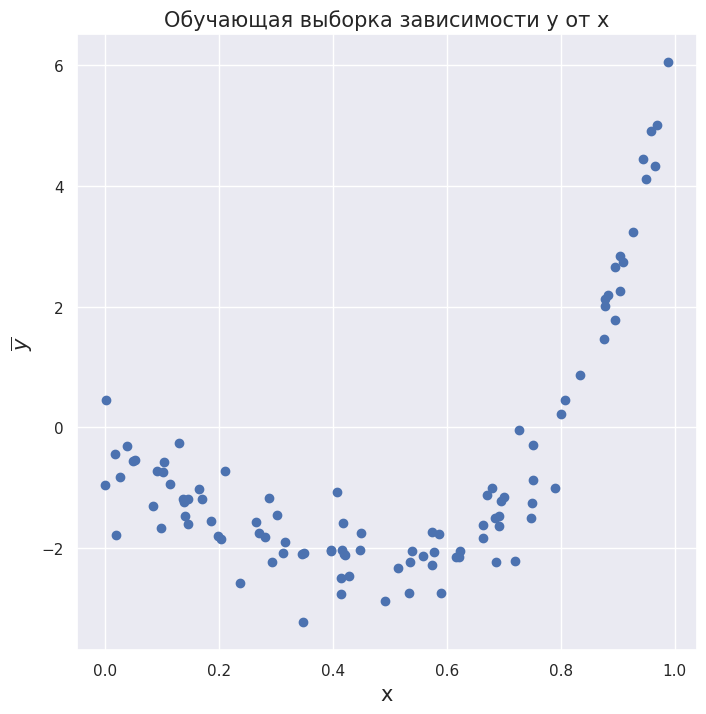

In [ ]:
np.random.seed(1)
X = np.random.uniform(0, 1, 100)
Y = (X - 0.8) * (X + 1) ** 5 + np.random.randn(100) * 0.5

plt.figure(figsize=(8, 8))
plt.scatter(X, Y)
plt.title("Обучающая выборка зависимости y от x", size=15)
plt.xlabel("x", size=15)
plt.ylabel(r'$\overline{y}$', size=15)
plt.show()

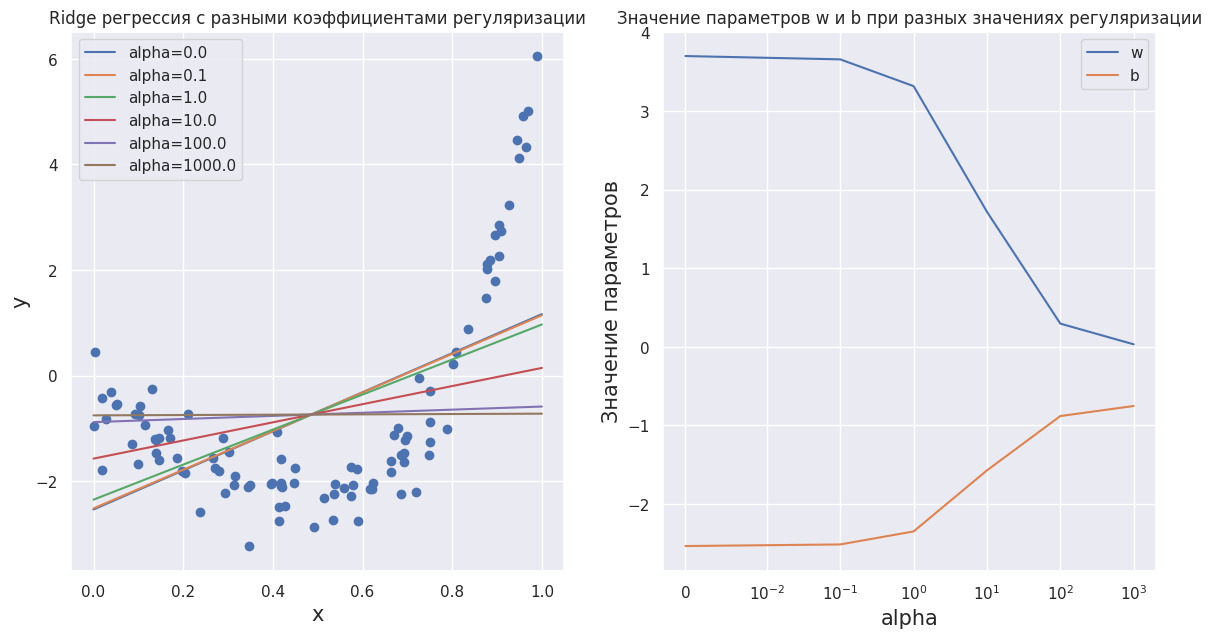

In [ ]:
x_axis = np.linspace(0, 1, 200)
fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
axs[0].scatter(X, Y)

w = []
b = []

alphas = [0.0, 0.1, 1.0, 10.0, 100.0, 1000.0]

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X[:, None], Y)
    pred = reg.predict(x_axis[:, None])
    w.append(reg.coef_[0])
    b.append(reg.intercept_)
    axs[0].plot(x_axis, pred, label="alpha=" + str(alpha))

axs[0].legend()
axs[0].set_xlabel("x", size=15)
axs[0].set_ylabel("y", size=15)
axs[0].set_title("Ridge регрессия с разными коэффициентами регуляризации")
axs[1].plot(alphas, w, label="w")
axs[1].plot(alphas, b, label="b")
axs[1].set_xlabel("alpha", size=15)
axs[1].set_ylabel("Значение параметров", size=15)
axs[1].set_title("Значение параметров w и b при разных значениях регуляризации")
axs[1].set_xscale("symlog", linthresh=0.01)
axs[1].legend()
plt.show()

-------------

Попробуем обучить линейную регрессию c $l_1$ регуляризацией на специальном датасете из sklearn

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)

Взглянем немножко на данные. Выведем средние значения каждого признака

In [ ]:
with np.printoptions(formatter={'float': '{: 0.3f}'.format}):
  print(X_train.mean(axis=0))

[ 3.871  28.668  5.438  1.097  1423.264  3.116  35.621 -119.558]


Нетрудно видеть, что масштаб у разных признаков сильно отличается. Это может приводить к разным неприятным эффектам. Подробнее эту проблему мы разберём в следующем задании.

In [ ]:
from sklearn.preprocessing import StandardScaler

### **Вопрос 8** (2 балла)

Отмасштабируйте данные при помощи класса StandardScaler. Выведите средние значения и дисперсии признаков на обучающей и тестовой выборках.

**Замечание:** Результат положите в переменные X_train_scaled и X_test_scaled , чтобы последующий код был рабочим

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Измерим качество прогнозатора. Будем использовать метрику RMSE.

In [ ]:
from sklearn.metrics import root_mean_squared_error

In [ ]:
reg = Lasso(alpha=0.5)
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Test RMSE = 0.9780


### **Вопрос 9** (1 балл)

чуть больше наказывает за ошибки, чем модуль, но чуть меньше, чем MSE ну и как бы ошибка отедельного одного предсказания гораздно меньше влияет на общую ошибку, таким образом нам чуть больше пофиг, если незначительное количество предсказаний получились с большой ошибкой.

### **Вопрос 10** (1 балл)

Насколько удачно измерять качество модели с помощью RMSE с учетом того, что оптимизация линейной регрессии происходит по MSE?

**Ваш ответ здесь**

-----

Проанализируем ошибку на обучающей выборке.

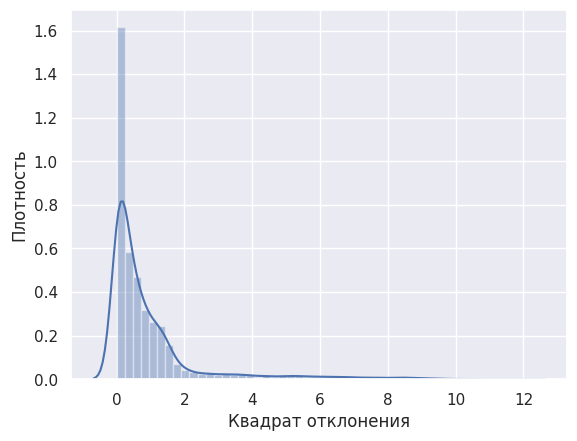

In [ ]:
error = (y_train - reg.predict(X_train_scaled)) ** 2
sns.distplot(error)
plt.xlabel("Квадрат отклонения")
plt.ylabel("Плотность")
plt.show()

Как видно, есть несколько объектов, на которых модель ошибается сильно. Давайте посмотрим на качество, если удалить эти объекты из обучающей выборки.

In [ ]:
mask = (error < np.quantile(error, 0.99))
reg.fit(X_train_scaled[mask], y_train[mask])
y_pred = reg.predict(X_test_scaled)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Test RMSE = 0.9717


Таким образом, можно улучшить качество линейной регрессии, если удалить из обучающей выборки выбросы. В данном примере, качество улучшилось не так сильно, но бывают ситуации, когда чистка обучающей выборки по ошибке, приводит к сильному улучшению качества.

Обратим внимание на веса модели. Почти все из них занулились! Это большое преимущество, так как разреживание весов позволяет отбирать нужные признаки, делая модель более лёгкой.

In [ ]:
reg.coef_

array([ 0.30658523,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ])

А теперь обучим с $l_2$ регуляризацией.

In [ ]:
reg = Ridge(alpha=0.5)
reg.fit(X_train_scaled, y_train)
print(reg.coef_)

[ 0.82540051  0.12701227 -0.24066504  0.27101941 -0.00317096 -0.04117445
 -0.87312407 -0.84556157]


Как видим, веса не разрежены, хотя и есть очень маленькие значения

### **Вопрос 11** (2 балла)

Приведите пример, когда линейная регрессия с $l_2$ регуляризацией гарантированно занулит какой-нибудь признак?

Если есть два признака, где один линейно зависит от другого, но численно получается в разы больше (например, если указаны скорости в м/с и в мм/с)

------

При обучении мы заранее не знаем, какое значение параметра регуляризации даст наилучшие результаты. Подобрать оптимальные параметры можно с помощью кросс-валидации. В sklearn есть несколько классов со встроенной кросс-валидацией

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

Воспользуемся классом GridSearch для перебора параметров по сетке.

* Для линейных регрессий перебирается параметр $\alpha$ - сила регуляризации. Обычно важнее перебирать порядок этого параметра, а не точное его значение. В силу этого сетку перебора будет удобно сделать через функцию np.logspace, например np.logspace(-3, 3, 10).

### Вопрос 12 (2 балла)

Воспользуйтесь классом [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) и подберите константы регуляризации для Lasso и Ridge регрессий. Измерьте качество обученных моделей. Сетка перебора должна быть логарифмической, из хотя бы 10 значений


**Подсказка:**
* Пример, как можно перебирать параметры в GridSearch у вложенных [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) можно [найти вот тут](https://www.kaggle.com/code/ilnazsalimov/gridsearch-with-pipeline)
* Обратите внимание, что сейчас мы сразу заносим масштабирование в Pipeline - чтобы иметь возможность сразу вызываться от оригинальных X_train, а также чтобы не было утечки данных при использовании GridSearch
* В GridSearch в качестве скоринговой функции можно подавать строковое описание функции из sklearn, которое [можно посмотреть вот тут](https://scikit-learn.org/stable/modules/model_evaluation.html), а также саму скоринговую функцию из sklearn или собственную функцию, сделанную [через make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer)

**Замечание:** Итоговое качество должно быть не больше 0.73 RMSE.

In [47]:
from sklearn.metrics import mean_pinball_loss

In [51]:
model_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", Lasso())
])

model_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("regr", Ridge())
])

parameters = {
    'regr__alpha': np.logspace(-3, 3, 10)
}

lasso_cv = GridSearchCV(
    model_lasso,
    cv=5,
    scoring="neg_root_mean_squared_error",
    param_grid = parameters
)

ridge_cv = GridSearchCV(
    model_ridge,
    cv=5,
    scoring="neg_root_mean_squared_error",
    param_grid = parameters
)

lasso_cv.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_cv.predict(X_test_scaled)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred_lasso))
print("MPL = %.4f" % mean_pinball_loss(y_test, y_pred_lasso))

ridge_cv.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_cv.predict(X_test_scaled)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred_ridge))
print("MPL = %.4f" % mean_pinball_loss(y_test, y_pred_ridge))

# Your code: фитим модели и измеряем качество на тесте
# Можно вызывать predict прямо от обученных lasso_cv и ridge_cv

Test RMSE = 0.7256
MPL = 0.2673
Test RMSE = 0.7241
MPL = 0.2665


Убедимся, что Lasso всё ещё зануляет признаки (скорее всего модель Lasso занулила хотя бы один).

In [52]:
lasso_cv.best_estimator_.named_steps["regr"].coef_

array([ 0.80235535,  0.13044694, -0.18274679,  0.21296615, -0.        ,
       -0.03656183, -0.82402123, -0.79344238])